In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow.keras as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import glob
import seaborn as sns
import json


In [2]:
# Define image size
s = 150

# Initialize dataset and labels
dataset = []
label = []
def decode_and_append_images(directory, class_label):
    images = glob.glob(directory + '/*')
    for image in images:
        img = cv2.imread(image)
        if img is not None:
            img = cv2.resize(img, (s, s))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = img / 255.0  # Normalize to [0, 1]
            img = img.astype(np.float32)  # Cast to float32
            dataset.append(img)
            label.append(class_label)
            
# Directories for different classes
directories = {
    'Caries': 0,
    'Gingivitis': 1,
    'Hypodontia': 2,
    'Mouth Ulcer': 3,
    'Tooth_discoloration_augmented': 4
}

# Load images
for directory, class_label in directories.items():
    decode_and_append_images(directory, class_label)
            

In [4]:
# Convert to numpy arrays
dataset = np.array(dataset)
label = np.array(label)

# Display the shape of the dataset
print("Dataset shape:", dataset.shape)
print("Label shape:", label.shape)

Dataset shape: (10357, 150, 150, 3)
Label shape: (10357,)


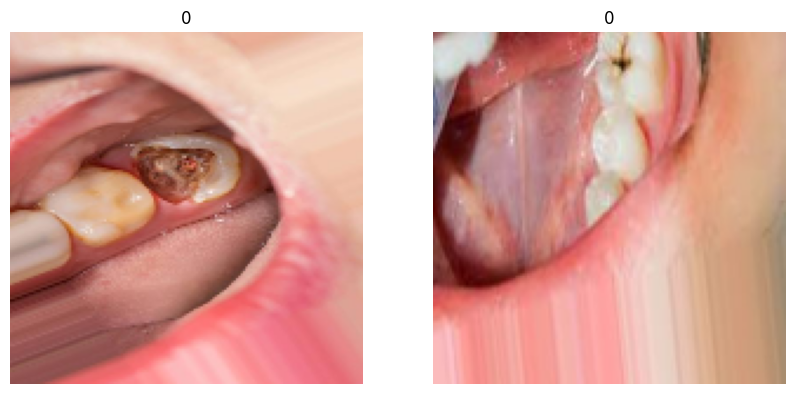

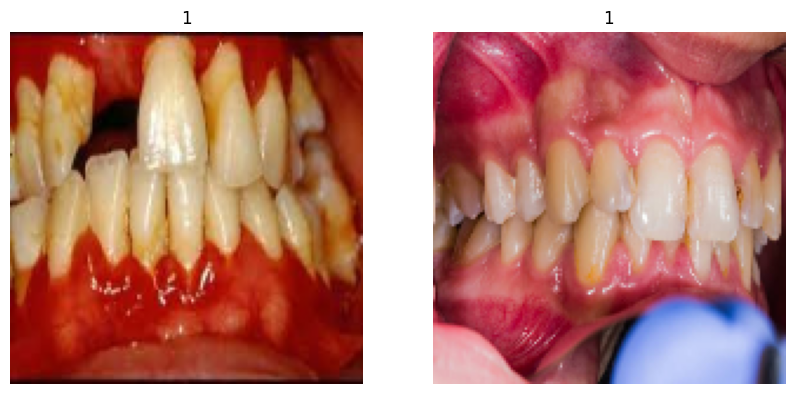

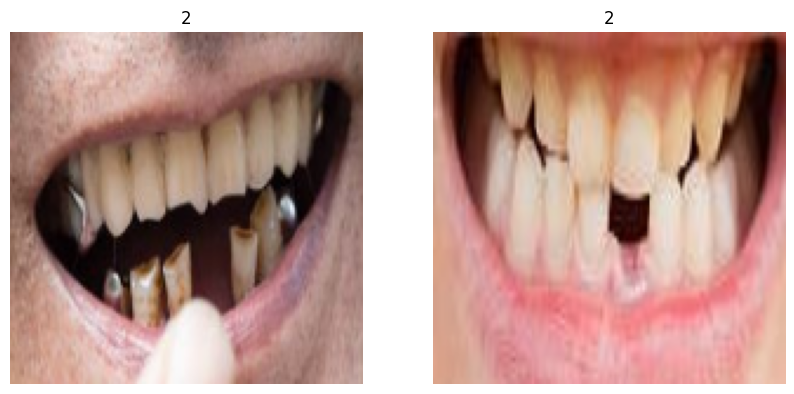

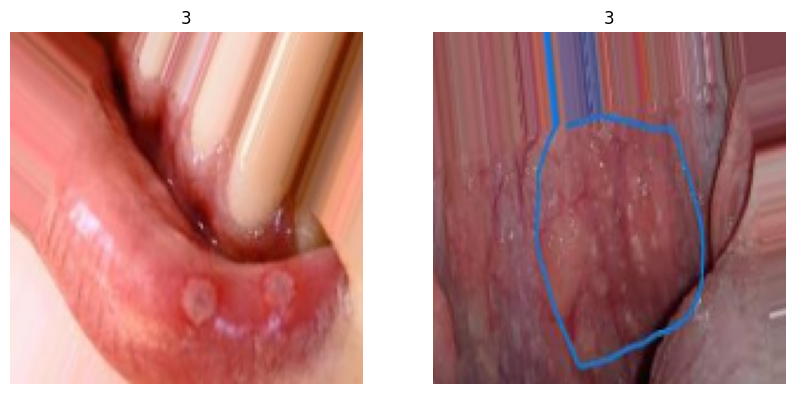

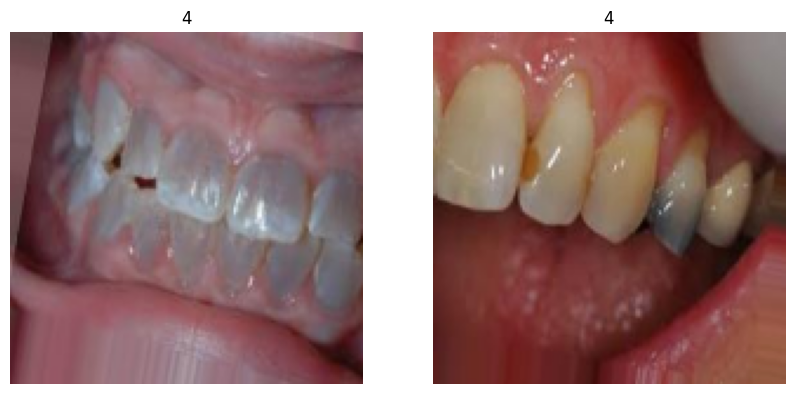

In [15]:
# Function to display two sample images per class
def display_sample_images(directory, class_label):
    images = glob.glob(directory + '/*')[:2]  # Get only 2 images
    plt.figure(figsize=(10, 5))
    for i, image_path in enumerate(images):
        img = cv2.imread(image_path)
        img = cv2.resize(img, (150, 150))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        plt.subplot(1, 2, i + 1)
        plt.imshow(img)
        plt.title(f'{class_label}')
        plt.axis('off')
    plt.show()

# Display sample images for each class
for directory, class_label in directories.items():
    display_sample_images(directory, class_label)


In [5]:
# Shuffle the data
dataset, label = shuffle(dataset, label, random_state=42)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size=0.25, stratify=label, random_state=43)

# One-hot encode the labels
y_train_one_hot = to_categorical(y_train, num_classes=5)
y_test_one_hot = to_categorical(y_test, num_classes=5)

In [6]:
# Build the model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(s, s, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)     

In [7]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [8]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train_one_hot, batch_size=32),
    epochs=30,
    validation_data=(X_test, y_test_one_hot),
    callbacks=[early_stop]
)

Epoch 1/30


243/243 [==============================] - 179s 638ms/step - loss: 1.2530 - accuracy: 0.4627 - val_loss: 0.9480 - val_accuracy: 0.5927
Epoch 2/30
243/243 [==============================] - 144s 594ms/step - loss: 0.9991 - accuracy: 0.5950 - val_loss: 0.7353 - val_accuracy: 0.7012
Epoch 3/30
243/243 [==============================] - 145s 595ms/step - loss: 0.8986 - accuracy: 0.6371 - val_loss: 0.8193 - val_accuracy: 0.6680
Epoch 4/30
243/243 [==============================] - 153s 627ms/step - loss: 0.8260 - accuracy: 0.6633 - val_loss: 0.7255 - val_accuracy: 0.7216
Epoch 5/30
243/243 [==============================] - 168s 690ms/step - loss: 0.7988 - accuracy: 0.6767 - val_loss: 0.6343 - val_accuracy: 0.7529
Epoch 6/30
243/243 [==============================] - 154s 635ms/step - loss: 0.7534 - accuracy: 0.6980 - val_loss: 0.6648 - val_accuracy: 0.7475
Epoch 7/30
243/243 [==============================] - 151s 620ms/step - loss: 0.7048 - accuracy: 0.7232 - val_loss: 0.6009

In [9]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_one_hot)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Get predicted probabilities
y_pred_prob = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Use the class labels for evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

81/81 [==============================] - 7s 84ms/step - loss: 0.4858 - accuracy: 0.8189
Loss: 0.48582664132118225, Accuracy: 0.8189189434051514
81/81 [==============================] - 15s 86ms/step
Accuracy: 0.8189189189189189
Precision: 0.841614856627054
Recall: 0.8189189189189189
F1 Score: 0.8161087850227386


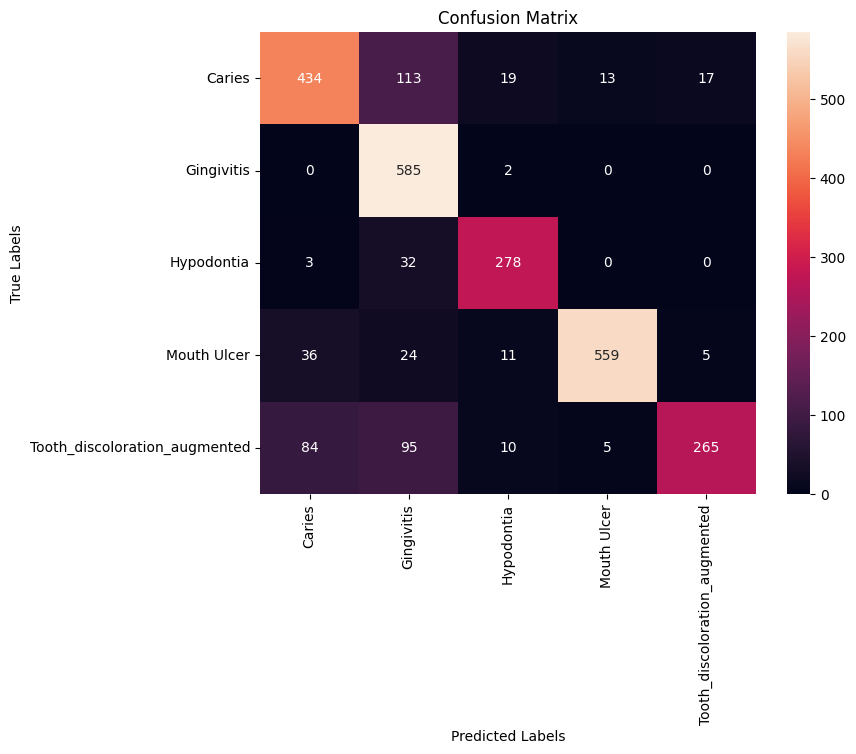

In [10]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=list(directories.keys()), yticklabels=list(directories.keys()))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

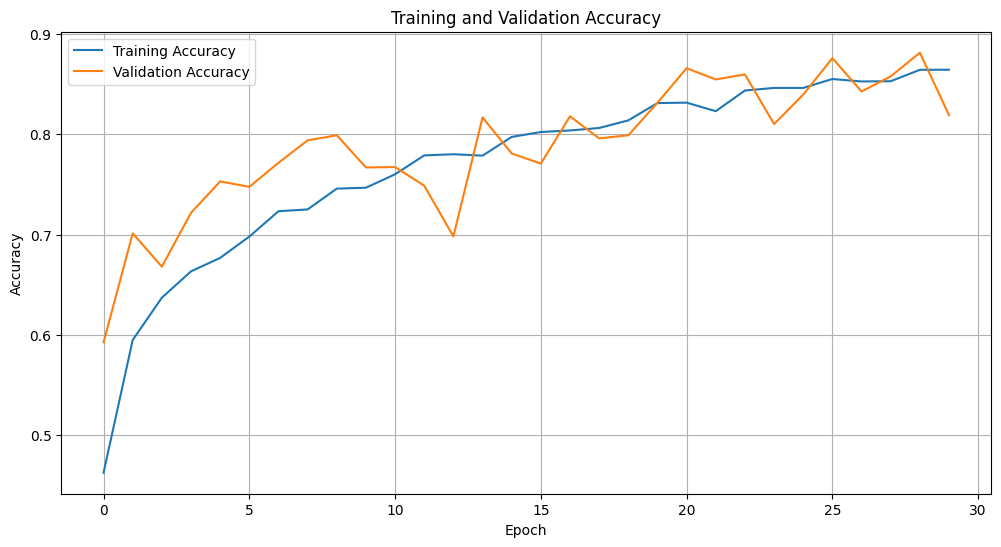

In [11]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Save the model
model.save("teeth.h5")

# Save the model architecture as JSON
model_json = model.to_json()
with open("teeth.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model architecture to 'teeth.json'")


Saved model architecture to 'teeth.json'
